## Dataset Description

* track_id - индентификатор трека.
* artists - имена исполнителей.
* album_name - название альбома.
* track_name - название трека.
* **popularity** - популярность трека от 0 до 100 (целевая переменная).
* duration_ms - продолжительность в миллисекундах.
* explicit - содержит ли трек вредный контент (ругательства и тп.)
* danceability - насколько трек танцевальный от 0 до 1.
* energy - насколько трек энергичный.
* key - тональность трека.
* loudness - громкость трека от -60 до ~0.
* mode - лад: 1 если минор, 0 если мажор.
* speechiness - насколько разговорный трек от 0 до 1.
* acousticness - насколько акустичный трек от 0 до 1.
* instrumentalness - насколько инструментален трек от 0 до 1.
* liveness - насколько "живой" трек от 0 до 1.
* valence - насколько позитивный трек от 0 до 1.
* tempo - темп трека в BPM.
* time_signature - тактовый размер.
* track_genre - жанр трека.вый размер.
track_genre - жанр трека.

## Импорт библиотек

In [56]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import PredictionErrorDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Nadam

In [2]:
plt.style.use('dark_background') # Ставим темный фон для графиков plt

# Загрузка датасета и EDA

In [3]:
data = pd.read_csv("/kaggle/input/spotify-data/spotify.csv")
data.drop(["Unnamed: 0"], axis=1, inplace=True)
data

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


### Удаление дубликатов

In [4]:
print('Изначальное количество дубликатов:', data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов после удаления:', data.duplicated().sum())

Изначальное количество дубликатов: 450
Количество дубликатов после удаления: 0


### Сравнение количества записей и количества идентификаторов

In [5]:
print("Количество записей:", data.shape[0])
print("Количество уникальных идентификаторов:", data.track_id.nunique())

Количество записей: 113550
Количество уникальных идентификаторов: 89741


Количество уникальных идентификаторов должно быть равно количеству записей (исходя из смысла данного признака). Рассмотрим подробнее распределение track_id.

In [6]:
data.track_id.value_counts()

track_id
6S3JlDAGk3uu3NtZbPnuhS    9
2kkvB3RNRzwjFdGhaUA0tz    8
2Ey6v4Sekh3Z0RUSISRosD    8
4XYieGKSlJlHpzB3bl6WMP    7
2qgXrzJsry4KgYoJCpuaul    7
                         ..
22Lhq4mVPFWv3bjchAFDOl    1
0oz9ITtPIt3iI1nzdVX9L2    1
1qFmSPALGSoqjbwM3br4Rl    1
1PTt5Oa80JGSBCrzzfhtn6    1
2hETkH7cOfqmz3LqZDHZf5    1
Name: count, Length: 89741, dtype: int64

Видим, что датасет заполнен таким образом, что track_id может повторяться до 9 раз. Посмотрим на примере чтобы выяснить с чем это связано.

In [7]:
data[data.track_id == '2qgXrzJsry4KgYoJCpuaul']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
50991,2qgXrzJsry4KgYoJCpuaul,The Local Train,Aalas Ka Pedh,Choo Lo,67,233630,False,0.512,0.695,4,-6.349,1,0.0271,0.0265,0.00815,0.146,0.351,145.957,4,hip-hop
54810,2qgXrzJsry4KgYoJCpuaul,The Local Train,Aalas Ka Pedh,Choo Lo,67,233630,False,0.512,0.695,4,-6.349,1,0.0271,0.0265,0.00815,0.146,0.351,145.957,4,indian
55770,2qgXrzJsry4KgYoJCpuaul,The Local Train,Aalas Ka Pedh,Choo Lo,67,233630,False,0.512,0.695,4,-6.349,1,0.0271,0.0265,0.00815,0.146,0.351,145.957,4,indie-pop
56768,2qgXrzJsry4KgYoJCpuaul,The Local Train,Aalas Ka Pedh,Choo Lo,67,233630,False,0.512,0.695,4,-6.349,1,0.0271,0.0265,0.00815,0.146,0.351,145.957,4,indie
79831,2qgXrzJsry4KgYoJCpuaul,The Local Train,Aalas Ka Pedh,Choo Lo,67,233630,False,0.512,0.695,4,-6.349,1,0.0271,0.0265,0.00815,0.146,0.351,145.957,4,pop-film
81370,2qgXrzJsry4KgYoJCpuaul,The Local Train,Aalas Ka Pedh,Choo Lo,67,233630,False,0.512,0.695,4,-6.349,1,0.0271,0.0265,0.00815,0.146,0.351,145.957,4,pop
90666,2qgXrzJsry4KgYoJCpuaul,The Local Train,Aalas Ka Pedh,Choo Lo,67,233630,False,0.512,0.695,4,-6.349,1,0.0271,0.0265,0.00815,0.146,0.351,145.957,4,rock


Судя по примеру (на других примерах закономерность та же) можно сказать, что связано такое дублирование с некорректным заполнением признака track_genre. Очевидно создатели датасета задублировали треки указав по отдельности каждый жанр к которому можно их отнести. Если бы это были одинковые треки, но выпущены с каким-то отличием (например трек был hip-hop и его перезаписали под rock), то должна была появится разница хотя бы в одном из признаков (кроме track_genre), но это не так. Следовательно можно точно утверждать, что такое явление было вызвано некорректным заполнением датасета.

В связи с предшествующими рассуждениями было принято решение создать три датасета:
* датасет без признака track_genre (с ним будем проводить основную работу).
* датасет с случайно выбранным для каждого трека track_genre (выбранным из тех которые для него указаны, если указан только один, то остается он).
* датасет с изначальным заполнением признака track_genre.

Последние два будут использованы только для обучения, чтобы узнать с каким датасетом модель лучше работает.

## Предподготовка датасетов

### Предподготовка датасета с изначальным заполнением признака track_genre

In [8]:
data_initial_genre = data.copy()

### Предподготовка датасета без признака track_genre

In [9]:
# Удаляем признак track_genre и удаляем дубликаты
data.drop(['track_genre'], axis=1, inplace=True)
data = data.drop_duplicates().reset_index(drop=True)
data.head(1)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4


In [10]:
print("Количество записей в датасете без track_genre:", data.shape[0])
print("Количество уникальных идентификаторов:", data_initial_genre.track_id.nunique())

Количество записей в датасете без track_genre: 90461
Количество уникальных идентификаторов: 89741


В первом датасете остались дубликаты идентификаторов. Посмотрим почему так произошло.

In [11]:
data.track_id.value_counts()

track_id
0ganZjtkMwkoRvYQk7te7h    2
3dwDBE5AMcHLxemIAEp2xb    2
65YXrDsZER1jlPAqFS9GDH    2
1S7hEPenrIVKVTuEjtXKz9    2
2ivnsOi3RcEbskFvTS9zt3    2
                         ..
5dTHtzHFPyi8TlTtzoz1J9    1
1m5HcIPX2T3wSoiHWhgwpA    1
0DWrG09StYVhLbeNLwAJ5w    1
6eYxmK9fdL4hwLnXG2zY3s    1
2hETkH7cOfqmz3LqZDHZf5    1
Name: count, Length: 89741, dtype: int64

Видим, что некоторые id повтоярются по два раза. Рассмотрим примеры.

In [12]:
data[data.track_id == '0ganZjtkMwkoRvYQk7te7h']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
8485,0ganZjtkMwkoRvYQk7te7h,Maneva,Mundo Novo,Tão Simples,49,142131,False,0.768,0.52,0,-7.375,0,0.0994,0.0912,0.000001,0.435,0.776,140.109,4
71350,0ganZjtkMwkoRvYQk7te7h,Maneva,Mundo Novo,Tão Simples,48,142131,False,0.768,0.52,0,-7.375,0,0.0994,0.0912,0.000001,0.435,0.776,140.109,4


In [13]:
data[data.track_id == '3dwDBE5AMcHLxemIAEp2xb']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
60893,3dwDBE5AMcHLxemIAEp2xb,Enrico Sangiuliano,Silence EP,Future Dust - Original Mix,60,509090,False,0.788,0.915,7,-4.904,1,0.0431,0.000695,0.839,0.0962,0.0934,132.005,4
86532,3dwDBE5AMcHLxemIAEp2xb,Enrico Sangiuliano,Silence EP,Future Dust - Original Mix,59,509090,False,0.788,0.915,7,-4.904,1,0.0431,0.000695,0.839,0.0962,0.0934,132.005,4


In [14]:
data[data.track_id == '65YXrDsZER1jlPAqFS9GDH']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
60890,65YXrDsZER1jlPAqFS9GDH,Boris Brejcha;Ginger,Timelapse,Darkness,0,478080,False,0.803,0.686,2,-9.289,1,0.0467,0.000513,0.839,0.0985,0.146,124.996,4
86545,65YXrDsZER1jlPAqFS9GDH,Boris Brejcha;Ginger,Timelapse,Darkness,10,478080,False,0.803,0.686,2,-9.289,1,0.0467,0.000513,0.839,0.0985,0.146,124.996,4


Разница есть только в popularity. Очевидно, что датасет выгрузили не моментально и за времы выгрузки некторые треки немного набрали прослушиваний. Оставим только максимальное значение popularity. При чем сделаем это в изначальном датасете чтобы избежать риска, что мы уже удалили записи в которых popularity еще чуть выше (не стал это делать раньше чтобы был виден ход мыслей). Также сделаем датасет в котором не будет записей с popularity=0, на случай если это является ошибкой заполнения.

In [15]:
# Группируем по track_id и выбираем максимальную популярность
max_popularity = data_initial_genre.groupby('track_id')['popularity'].transform('max')
data_initial_genre['popularity'] = max_popularity

Теперь выполним те же шаги с датасетом без жанров заново.

In [16]:
# Создаем копию изначального датасета
data = data_initial_genre.copy()
# Удаляем признак track_genre и удаляем дубликаты
data.drop(['track_genre'], axis=1, inplace=True)
data = data.drop_duplicates().reset_index(drop=True)
data.head(1)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4


И выполним проверку тех id.

In [17]:
data[data.track_id == '0ganZjtkMwkoRvYQk7te7h']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
8485,0ganZjtkMwkoRvYQk7te7h,Maneva,Mundo Novo,Tão Simples,49,142131,False,0.768,0.52,0,-7.375,0,0.0994,0.0912,0.000001,0.435,0.776,140.109,4


In [18]:
data[data.track_id == '3dwDBE5AMcHLxemIAEp2xb']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
60890,3dwDBE5AMcHLxemIAEp2xb,Enrico Sangiuliano,Silence EP,Future Dust - Original Mix,60,509090,False,0.788,0.915,7,-4.904,1,0.0431,0.000695,0.839,0.0962,0.0934,132.005,4


Видим, что остались записи с максимальной popularity из доступных (чего мы и хотели).

### Подготовка датасета без popularity=0

In [19]:
data_wo_zeroes = data_initial_genre.copy()
zeroes = data_wo_zeroes[data_wo_zeroes.popularity < 0.1]
data_wo_zeroes = data_wo_zeroes.drop(zeroes.index)

### Подготовка датасета со случайным track_genre

In [20]:
# Создаем копию изначального датасета
data_random_genre = data_initial_genre.copy()
# Перемешиваем датасет (для гарантированности случайности удаления)
data_random_genre = data_random_genre.sample(frac=1)
# Удаляем дубликаты по track_id оставляя первую запись
data_random_genre = data_random_genre.drop_duplicates(subset='track_id', keep='first').reset_index(drop=True)
data_random_genre.head(1)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,2pDJGnILrr8pN3N4RNHGNt,Jahshii;Sonovic,Media,Media,23,202699,True,0.665,0.522,5,-7.895,0,0.231,0.373,0.0,0.153,0.742,180.011,4,j-dance


### Проверка размеров датасетов

In [21]:
print("Количество уникальных идентификаторов:", data_initial_genre.track_id.nunique())
print("Количество записей в датасете без track_genre:", data.shape[0])
print("Количество записей в датасете со случайным track_genre:", data_random_genre.shape[0])
print("Количество записей в датасете с изначальным track_genre:", data_initial_genre.shape[0])
print("Количество записей в датасете без popularity=0:", data_wo_zeroes.shape[0])

Количество уникальных идентификаторов: 89741
Количество записей в датасете без track_genre: 89741
Количество записей в датасете со случайным track_genre: 89741
Количество записей в датасете с изначальным track_genre: 113550
Количество записей в датасете без popularity=0: 97891


Первые два датасета стали размером равным количеству идентификаторов (что и требовалось).

## EDA

### Информация

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89741 entries, 0 to 89740
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          89741 non-null  object 
 1   artists           89740 non-null  object 
 2   album_name        89740 non-null  object 
 3   track_name        89740 non-null  object 
 4   popularity        89741 non-null  int64  
 5   duration_ms       89741 non-null  int64  
 6   explicit          89741 non-null  bool   
 7   danceability      89741 non-null  float64
 8   energy            89741 non-null  float64
 9   key               89741 non-null  int64  
 10  loudness          89741 non-null  float64
 11  mode              89741 non-null  int64  
 12  speechiness       89741 non-null  float64
 13  acousticness      89741 non-null  float64
 14  instrumentalness  89741 non-null  float64
 15  liveness          89741 non-null  float64
 16  valence           89741 non-null  float6

* track_id, artists, album_name, track_name - данные строчного типа.
* explicit - данные булевого типа.
* все остальные признаки - данные численного типа (int64/float64)

### Пропущенные значения

In [23]:
data.isna().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

Пропусков слишком мало, можно просто удалить записи с ними.

In [24]:
data = data.dropna()
data_random_genre = data_random_genre.dropna()
data_initial_genre = data_initial_genre.dropna()
data_wo_zeroes = data_wo_zeroes.dropna()

### Гистограммы распределения численных признаков

In [25]:
def plot_hist(data, col_names, num_cols_fig=2):
    num_rows_fig = int(np.ceil(len(col_names)/num_cols_fig))
    fig = make_subplots(rows = num_rows_fig, cols = num_cols_fig, subplot_titles = (col_names))
    for idx, column_name in enumerate(col_names):
        fig.add_trace(go.Histogram(x=data[column_name], nbinsx = 20), 
                     row = idx//num_cols_fig+1, col=idx%num_cols_fig+1)
    fig.update_layout(height=250*num_rows_fig, width=num_cols_fig*400, showlegend=False, template = "plotly_dark")
    fig.show(renderer='iframe')

num_cols = ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
plot_hist(data, num_cols, num_cols_fig=3)

##### Popularity:
* Много значений близких к нулю. Много исполнителей кто не смог добиться даже минимального успеха, либо трек только вышел на момент выгрузки и еще не успел набрать прослушиваний.
* Большинство треков в промежутке от 20 до 60. Болишинство треков выпускаемых профессиональными исполнителями набирают средние прослушивания, так скажем не хиты, но на уровне.
* От 70 начинаются относительные хиты, которых довольно мало (около 3000).
* 43 трека с популярностью >90. Настолько редко выходят общепризнанные хиты, что количество таких треков меньше 50.

##### Duration_ms:
* Нужно смотреть подробнее, но уже заметно наличие выбросов.

##### Danceability:
* Медиана близка к 0.6. Есть небольшой уклон в танцевальность, но в целом большинство треков выходит со средним значением.

##### Energy:
* Мода находится около 0.9. Есть явный уклон в энергичность, почти все треки выходят энергичными.

##### Key:
* Относительно равномерно распределен за исключением 3 (значительно меньше чем остальных).

##### Loudness:
* Большинство значений от -15 до 0. Видимо почти все треки выпускаются с примерно одинаковой громкостью за исключением некоторых.
* Довольно мало значений меньше -30, нужно посмотреть подробнее.

##### Speechiness, acousticness, instrumentalness, liveness:
* У всех трех признаков явное преобладание значений близких к нулю.
* Speechiness стоит посмотреть на точечном графике.
* Instrumentalness иметь небольшой пик около 0.9. Возможно это вызванно каким-то определенным жанром (по типу классической музыки).

##### Valence:
* Довольно равномерное распределение. Скорее всего вызвано тем что выпускаются как позтивные так и печальные треки и нет явного уклона в какую-то сторону.

##### Tempo:
* Довольно равномерно распределение с медианой около 115. Большинство треков выпускается примерно с одной частотой за редким исключением.
* Возможны выбросы около 0. Нужно посмотреть подробнее.

### Boxplot для duration_ms, loudness, tempo

In [26]:
def plot_boxplot(data, col_names):
    fig = make_subplots(rows = len(col_names), cols = 1, subplot_titles=(col_names))
    for idx, column_name in enumerate(col_names):
        fig.add_trace(px.box(data, x=column_name, title=column_name).data[0], 
                     row = idx+1, col=1)
    fig.update_layout(height=300 * len(col_names), width=1200, template='plotly_dark')
    fig.show(renderer='iframe')

plot_boxplot(data, ['duration_ms', 'loudness', 'tempo'])

###### Duration_ms:
* Медиана ≈ 213000. Что примерно равно 4 минутам.
* Можно удалить со значением больше 1.6М.

###### Loudness:
* Медиана ≈ -7.
* Можно удалить со значением меньше -41 или больше 3.

###### Tempo:
* Медиана ≈ 122.
* Можно удалить со значением меньше 34 или больше 213.

In [27]:
def delete_on_dur(dataset):
    trash_dur = dataset[dataset.duration_ms > 1000000]
    dataset.drop(trash_dur.index, inplace=True)

delete_on_dur(data)
delete_on_dur(data_random_genre)
delete_on_dur(data_initial_genre)
delete_on_dur(data_wo_zeroes)

In [28]:
def delete_on_lou(dataset):
    trash_lou = dataset[(dataset.loudness < -36.6) | (dataset.loudness > 3)]
    dataset.drop(trash_lou.index, inplace=True)

delete_on_lou(data)
delete_on_lou(data_random_genre)
delete_on_lou(data_initial_genre)
delete_on_lou(data_wo_zeroes)

In [29]:
def delete_on_tem(dataset):
    trash_tem = dataset[(dataset.tempo < 34) | (dataset.tempo > 213)]
    dataset.drop(trash_tem.index, inplace=True)

delete_on_tem(data)
delete_on_tem(data_random_genre)
delete_on_tem(data_initial_genre)
delete_on_tem(data_wo_zeroes)

### Точечный график для speechiness

In [30]:
def plot_scatter(data, col_names):
    fig = make_subplots(rows = len(col_names), cols = 1, subplot_titles=(col_names))
    for idx, column_name in enumerate(col_names):
        fig.add_trace(px.scatter(data, x=column_name, title=column_name).data[0], 
                     row = idx+1, col=1)
    fig.update_layout(height=400 * len(col_names), width=1200, template='plotly_dark')
    fig.show(renderer='iframe')
    
plot_scatter(data, ['speechiness'])

Слишком много записей больше 0.6, не получится удалить без потери значимости.

### Количество значений artists

In [31]:
data.artists.nunique()

31322

Учитывая, что в этом датасете больше 80000 записей, модели могут выявить полезную информацию из признака artists.

### Распределение признака time_signature

In [32]:
data.time_signature.value_counts()

time_signature
4    79375
3     7558
5     1570
1      837
0        5
Name: count, dtype: int64

Таким оставлять этот признак не имеет смысла из-за слишком нерепрезентативного распределение (слишком много со значением 4).

### Средняя популярность по каждому жанру

In [33]:
genre_popularity = data_wo_zeroes.groupby('track_genre')['popularity'].mean().reset_index() # Выбрал именно data_wo_zeroes чтобы среднеее было гарантировано посчитано без ошибок
genre_popularity = genre_popularity.sort_values(by='popularity', ascending=False)
rows = []
for i in range(0, len(genre_popularity), 6):
    genres = genre_popularity.iloc[i : i + 6]
    row = []
    for j in range(6):
        row.append(genres.iloc[j]['track_genre'])
        row.append(genres.iloc[j]['popularity'])
    rows.append(row)

col_names = []
for i in range(1, 7):
    col_names.append(f'track_genre {i}')
    col_names.append(f'mean popularity {i}')

table = pd.DataFrame(rows, columns=col_names)
table

,track_genre 1,mean popularity 1,track_genre 2,mean popularity 2,track_genre 3,mean popularity 3,track_genre 4,mean popularity 4,track_genre 5,mean popularity 5,track_genre 6,mean popularity 6
0,pop-film,59.399198,k-pop,59.276151,pop,58.238678,electro,57.823718,house,57.030050,chill,55.840791
1,indie-pop,54.814016,edm,54.786499,metal,54.777638,indie,54.052414,sad,53.164467,hip-hop,53.100000
2,grunge,51.544225,alt-rock,51.345979,progressive-house,50.905229,soul,50.662404,emo,50.557773,songwriter,50.185676
3,singer-songwriter,50.185676,indian,50.156504,piano,50.138239,british,50.086957,hard-rock,49.529617,anime,49.160444
4,deep-house,48.961665,psych-rock,48.611429,folk,48.194622,j-pop,48.008168,sertanejo,47.932933,blues,47.624809
5,ambient,47.246154,electronic,47.007423,alternative,46.400000,brazil,46.239085,funk,45.535211,mandopop,45.527806
6,pagode,45.433846,r-n-b,45.396786,metalcore,45.337161,acoustic,44.956614,punk,44.804220,dance,44.736634
7,french,44.582334,dubstep,44.048958,swedish,43.801887,sleep,43.555911,disco,43.164948,garage,42.676653
8,punk-rock,42.646205,world-music,42.534219,jazz,42.507886,mpb,42.492708,spanish,42.466965,dub,42.225738
9,techno,42.132543,gospel,41.929364,j-rock,41.878476,forro,41.831663,groove,41.674393,turkish,41.637666


Топ 5 жанров: pop-film, k-pop, pop, electro, house, chill.

Антитоп 5 жанров: grindcore, chicago-house, detroit-techno, romance, iranian.

Есть достаточно большая разница между жанрами в разных концах таблицы. Скорее всего будь этот признак корректно заполнен, модели работали бы значительно лучше.

### Графики плотности распределения popularity VS один из признаков

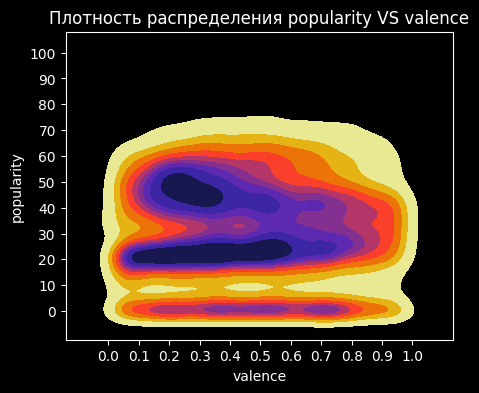

In [34]:
def kde_plot_popularity(data, x, xrange=None, n_sample=30000):
    plt.figure(figsize=(5, 4))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.kdeplot(data=data.sample(n_sample), x=x, y='popularity', fill=True, cmap='CMRmap_r')
    plt.title(f'Плотность распределения popularity VS {x}')
    plt.xlabel(x)
    plt.ylabel('popularity')
    plt.xticks(xrange)
    plt.yticks(np.arange(0, 101, 10))
    plt.show()

kde_plot_popularity(data, 'valence', np.arange(0.0, 1.01, 0.1))

* Треки с популярностью =0 имеют разную позитивность (это скорее всего связано с заполнением датасета).
* Треки с valence в диапазоне от 0.05 до 0.6 часто имеют популярность около 20.
* Треки с valence в диапазоне от 0.15 до 0.4 часто имеют популярность около 50.
* Сильно позитивные (>0.7) треки редко имеют популярность >50.

В целом заметно, что более грустные треки обычно популярнее.

График для energy<=0.5


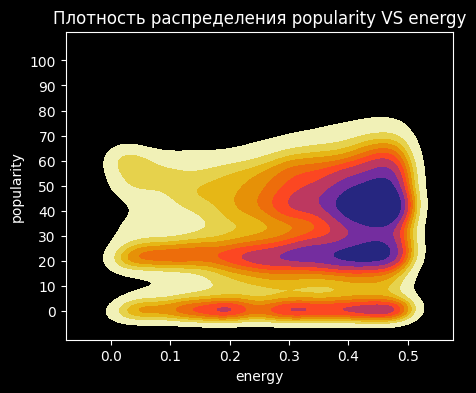

In [35]:
data_energy_low = data[data.energy <= 0.5]
data_energy_high = data[data.energy > 0.5]

print("График для energy<=0.5")
kde_plot_popularity(data_energy_low, 'energy', np.arange(0.0, 0.51, 0.1), n_sample=data_energy_low.shape[0])

График для energy>0.5


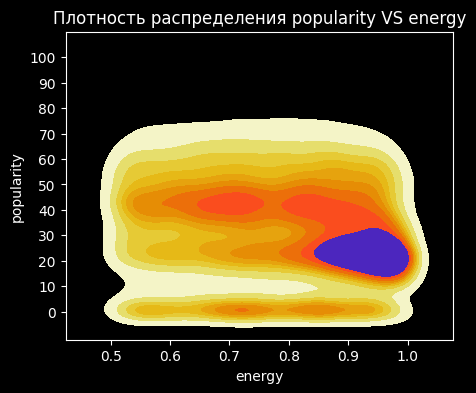

In [36]:
print("График для energy>0.5")
kde_plot_popularity(data_energy_high, 'energy', np.arange(0.5, 1.01, 0.1))

Разделил на два графика из-за слишком большой отрицательной ассиметрии распределения energy.

Первый график:
* Слишком мало записей с energy<0.2. Единственное, что там можно заметить это наличей какого-то количества записей с energy~0.05 и popularity>60.
* В остальных значениях energy плотность похожа.
* Есть заметные преобладания плотности с popularity ~45 и ~20.
* Если сравнить energy~0.4 и energy~0.5, то при 0.5 немного чаще популярность больше 50.

Второй график:
* Единственное значительное увеличение плотности при popularity~25 и energy>0.85.
* В остальном плотности очень похожи, изменения появляются только из-за неравномерного распределения energy.

В целом, довольно сложно отметить какие-то полезные закномерности из графиков. Скорее всего корреляция между этими признаками очень низкая.

### Матрица корреляции

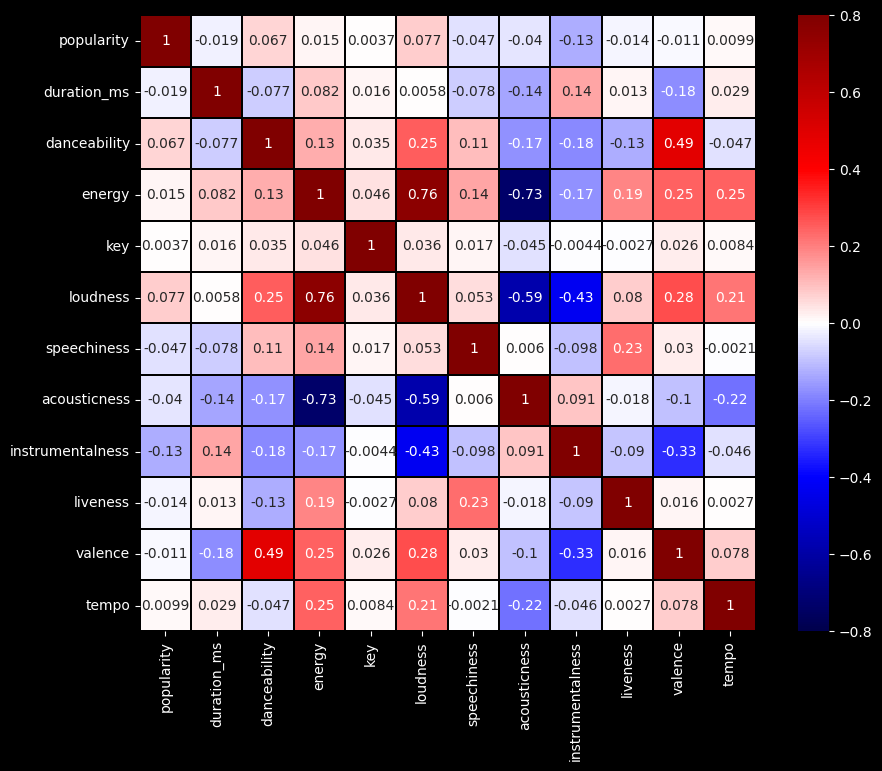

In [37]:
corr=data[num_cols].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, vmin=-.8, vmax=.8, linewidths=0.01, square=True,annot=True,cmap='seismic',linecolor="black")
plt.show()

#### Выводы по каждому признаку:

##### Popularity:
* Нет линейных зависимостей, таргет имеет низкую корреляцию со всеми признаками.
* Наибольшая (по модулю) отрицательная корреляция с instrumentalness, что в целом совпадает с реальностью (сейчас инструментальная музыка не пользуется большой популярностью).
* Есть небольшая положительная корреляция с loudness. Скорее всего треки которые чуть громче среднего популярнее остальных.

##### Duration_ms:
* Небольшая положительная корреляция с instrumentalness. Что в целом закономерно, обычно инструментальные треки дольше остальных.
* Небольшая отрицательная корреляция с valence. Похоже грустные треки обычно короче позитивных.

##### Danceability:
* Довольно большая положительная корреляция с valence. Закономерно, что позитивные треки более танцевальные чем грустные.
* Небольшая положительная корреляция с loudness. Также логично, так как танцевальные треки обычно громче остальных.
* Небольшая отрицательная корреляция с acousticness и instrumentalness. Инструментальность и акустичность в реальности тоже слабо подходят танцевальности.

##### Energy:
* Очень большая положительная корреляция с loudness. Чем громче трек тем он энергичнее. Возможно стоит как-то обработать эти признаки.
* Очень большая отрицательная корреляция с acousticness. Акустичные треки освершенно не энергичные. Возможно стоит как-то обработать эти признаки.

##### Key:
* Нет линейных зависимостей.

##### Loudness:
* Довольно большая отрицательная корреляция с acousticness. Громкие треки не акустичны.

##### Speechiness:
* Небольшая положительная корреляция с liveness. "Живость" трека подразумевает, что там будет больше пения.

##### Acousticness:
* Отрицательная корреляция со всеми (в основном небольшая) признаками кроме instrumentalness.

##### Instrumentalness:
* Довольно большая отрицательная корреляция с loudness. Инструментальные треки тише остальных.

##### Liveness:
* Небольшая положительная корреляция с energy. "Живая" музыка немного энергичнее.

##### Valence:
* Небольшая положительная корреляция с loudness и energy. Позитивная музыка громче и энергичнее.
* Небольшая отрицательная корреляция с instrumentalness. Инструментальные треки менее позитивные.

##### Tempo:
* Небольшая положительная корреляция с energy и loudness. Быстрые треки энергичнее и громче.
* Небольшая отрицательная корреляция с acousticness. Акустичные треки медленее.

#### Общие выводы:
* Целевая переменная не имеет сильных линейных зависимостей.
* Energy и loudness очень похожи.
* Acousticness сильно отрицательно коррелирует с energy и loudness.
* Valence и danceability довольно сильно скоррелированы.
* Acousticness и instrumentalness низко скоррелированы, но находятся в похожих зависимостях с остальными признаками.

# Feature Engineering

## Создание is_single

Создам принзнак который будет отображать вышел трек как часть альбома или он является синглом

In [38]:
grouped = data.groupby(['artists', 'album_name']).agg({'track_id': 'count'}).reset_index().rename(columns={'track_id': 'track_count_per_album'})
grouped

,artists,album_name,track_count_per_album
0,!nvite,pagadoff,1
1,!nvite,strolling,1
2,"""Puppy Dog Pals"" Cast",Puppy Dog Pals: Disney Junior Music,2
3,"""Weird Al"" Yankovic","""Weird Al"" Yankovic",4
4,"""Weird Al"" Yankovic",Bad Hair Day,1
...,...,...,...
62536,黃妃,水水水,1
62537,黃妃,非常妃,1
62538,黃小琥,簡單不簡單,1
62539,黃敏華,關不掉的聲音,1


In [39]:
def add_is_single(dataset):
    dataset = dataset.merge(grouped, on=['artists', 'album_name'], how='left')
    dataset['is_single'] = dataset['track_count_per_album'].apply(lambda x: 1 if x==1 else 0)
    return dataset

data = add_is_single(data)
data_random_genre = add_is_single(data_random_genre)
data_initial_genre = add_is_single(data_initial_genre)
data_wo_zeroes = add_is_single(data_wo_zeroes)

data.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_count_per_album,is_single
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,1,1
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,1,1
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,1,1
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,1,1
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,2,0


## Создание is_time_signature_over_3

Создадим признак показывающий time_signature больше или меньше-равно трех.

In [40]:
data['is_time_signature_over_3'] = data['time_signature'].apply(lambda x: 1 if x>3 else 0)

data_random_genre['is_time_signature_over_3'] = data_random_genre['time_signature'].apply(lambda x: 1 if x>3 else 0)

data_initial_genre['is_time_signature_over_3'] = data_initial_genre['time_signature'].apply(lambda x: 1 if x>3 else 0)

data_wo_zeroes['is_time_signature_over_3'] = data_wo_zeroes['time_signature'].apply(lambda x: 1 if x>3 else 0)

## Получение нового признака из loudness и energy

Выше мы выяснили, что между loudness и energy высокая корреляция (0.76). Нужно как-то их обработать чтобы избежать мультиколлинеарности. Рассмотрим как распределены эти признаки относительно друг друга.

In [41]:
# Нормализуем loudness
scaler = MinMaxScaler()
data['loudness'] = scaler.fit_transform(data[['loudness']])

data_random_genre['loudness'] = scaler.fit_transform(data_random_genre[['loudness']])

data_initial_genre['loudness'] = scaler.fit_transform(data_initial_genre[['loudness']])

data_wo_zeroes['loudness'] = scaler.fit_transform(data_wo_zeroes[['loudness']])

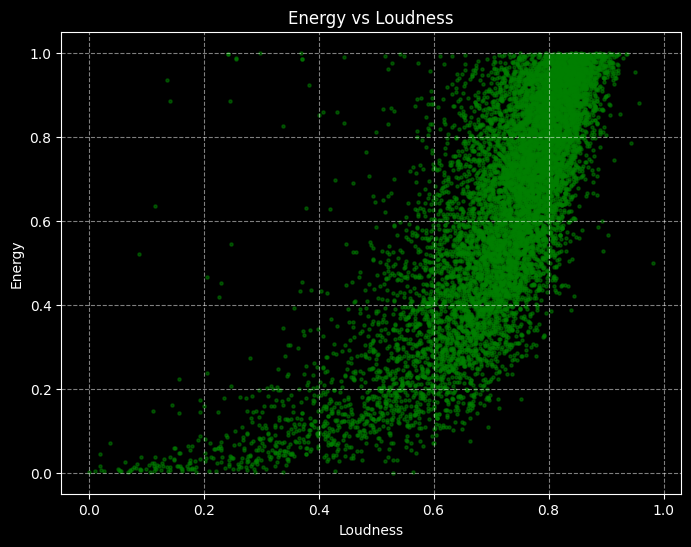

In [42]:
def scatter_lou_ene(data, n_sample):
    data_sample = data.sample(n=n_sample, random_state=42)
    
    plt.figure(figsize=(8, 6), facecolor='black')
    
    plt.scatter(data_sample['loudness'], data_sample['energy'], s=5, alpha=0.5, color='green')
    
    plt.title('Energy vs Loudness', color='white')
    plt.xlabel('Loudness', color='white')
    plt.ylabel('Energy', color='white')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(color='white')
    plt.yticks(color='white')
    plt.show()

scatter_lou_ene(data, 10000)

Видим, что признаки изменяются по очень похожей закономерности. Заменим их на произведение.

In [43]:
data['energy_loudness_product'] = data['energy'] * data['loudness']

data_random_genre['energy_loudness_product'] = data_random_genre['energy'] * data_random_genre['loudness']

data_initial_genre['energy_loudness_product'] = data_initial_genre['energy'] * data_initial_genre['loudness']

data_wo_zeroes['energy_loudness_product'] = data_wo_zeroes['energy'] * data_wo_zeroes['loudness']

data.sample(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_count_per_album,is_single,is_time_signature_over_3,energy_loudness_product
50726,2fGCeXhk6kUvciF4WsoeXq,Alireza Mashayekhi;National Symphony Orchestra...,"Symphony, No. 4 (Zagros), Op. 103","Movement, No. 1",0,375248,False,0.193,0.236,6,...,0.919000,0.742000,0.1370,0.0339,78.039,4,3,0,1,0.115189
75600,3uweF2P3NCKG12LpNvVcXB,Viti Ruiz,Sedúceme,Me Muero Por Estar Contigo,31,358786,False,0.630,0.726,7,...,0.769000,0.000025,0.1330,0.8370,94.660,4,2,0,1,0.580822
57594,69vlMrzHwATKzupwNcUPyK,Bad Bunny;Daddy Yankee,YHLQMDLG,La Santa,84,206420,True,0.744,0.868,1,...,0.032600,0.000000,0.0822,0.5860,93.037,4,1,1,1,0.710533
60793,5L198N7yNzYIbj3V5UsbbB,Moonbootica,Techno Top 50: Edition 2022,Say More,0,341670,False,0.800,0.841,6,...,0.000067,0.564000,0.0366,0.7630,124.003,4,1,1,1,0.626806
28653,0b5CzUhyShYuDdtW5J4wm2,Calvin Harris;Charlie Puth;Shenseea,Funk Wav Bounces Vol. 2,Obsessed (with Charlie Puth & Shenseea),73,226497,True,0.733,0.740,1,...,0.246000,0.000033,0.2990,0.9030,99.993,4,1,1,1,0.571351


## Корреляция новых признаков с таргетом

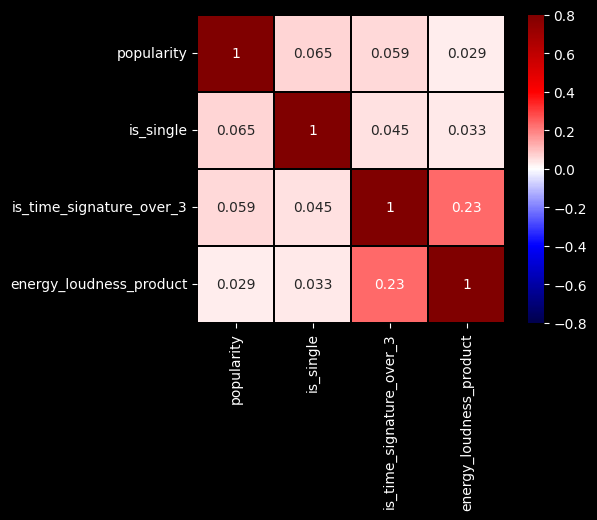

In [44]:
corr=data[['popularity', 'is_single', 'is_time_signature_over_3', 'energy_loudness_product']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, vmin=-.8, vmax=.8, linewidths=0.01, square=True,annot=True,cmap='seismic',linecolor="black")
plt.show()

На удивление получили небольшую положительную корреляцию с is_time_signature_over_3. С остальными новыми признаками таргет слабо коррелирует.

## Удаление лишних признаков

In [45]:
droped_cols = ['energy', 'loudness', 'track_count_per_album', 'track_id', 'album_name', 'track_name', 'time_signature']

data.drop(droped_cols, axis=1, inplace=True)

data_random_genre.drop(droped_cols, axis=1, inplace=True)

data_initial_genre.drop(droped_cols, axis=1, inplace=True)

data_wo_zeroes.drop(droped_cols, axis=1, inplace=True)

data.sample(5)

,artists,popularity,duration_ms,explicit,danceability,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,is_single,is_time_signature_over_3,energy_loudness_product
65646,DJ Ötzi;Nik P.,25,222266,False,0.690,11,0,0.0363,0.0388,0.000000,0.3610,0.705,126.029,1,1,0.714868
55233,TWICE,73,204167,False,0.702,10,1,0.0539,0.0542,0.000000,0.0877,0.419,144.896,1,1,0.550880
25104,YSA,20,146226,False,0.517,9,0,0.1600,0.9910,0.969000,0.0926,0.316,123.396,1,1,0.023827
22981,Surgeon,7,274866,False,0.741,11,1,0.1120,0.3800,0.879000,0.1110,0.482,137.728,0,1,0.490789
78307,Angela Lansbury;David Ogden Stiers;Jerry Orbac...,54,138413,False,0.581,1,1,0.0409,0.8430,0.000003,0.0951,0.428,126.076,1,1,0.145731


# Подготовка данных и обучение моделей

### Кодирование категориальных признаков

In [46]:
le_encoder = LabelEncoder()
le_cols = ['artists', 'explicit', 'track_genre']
for col in le_cols:
    if col != 'track_genre':
        data[col] = le_encoder.fit_transform(data[col])
    
    data_random_genre[col] = le_encoder.fit_transform(data_random_genre[col])
    data_initial_genre[col] = le_encoder.fit_transform(data_initial_genre[col])
    data_wo_zeroes[col] = le_encoder.fit_transform(data_wo_zeroes[col])

### Разделение на выборки

In [47]:
def data_split(dataset):
    x, y = dataset.drop(columns=['popularity']), dataset['popularity']
    return train_test_split(x, y, test_size=0.3, random_state=42)

x_train, x_test, y_train, y_test = data_split(data)
x_train_r, x_test_r, y_train_r, y_test_r = data_split(data_random_genre)
x_train_i, x_test_i, y_train_i, y_test_i = data_split(data_initial_genre)
x_train_z, x_test_z, y_train_z, y_test_z = data_split(data_wo_zeroes)

### Подготовка числовых признаков

In [48]:
def scaler_nums(train, test):
    st_scaler = StandardScaler()
    st_cols = ['duration_ms', 'danceability', 'tempo']
    train[st_cols] = st_scaler.fit_transform(train[st_cols])
    test[st_cols] = st_scaler.transform(test[st_cols])
    
    po_transformer = PowerTransformer()
    po_cols = ['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'energy_loudness_product']
    train[po_cols] = po_transformer.fit_transform(train[po_cols])
    test[po_cols] = po_transformer.transform(test[po_cols])

    return train, test

x_train, x_test = scaler_nums(x_train, x_test)
x_train_r, x_test_r = scaler_nums(x_train_r, x_test_r)
x_train_i, x_test_i = scaler_nums(x_train_i, x_test_i)
x_train_z, x_test_z = scaler_nums(x_train_z, x_test_z)

### Вспомогательные функции

In [49]:
def calculate_metric(model, X, y):
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred), r2_score(y, y_pred)

def show_metrics(model, x_train, y_train, x_test, y_test):
    print(f'\t\t mse \t\t r2')
    print(f'train\t', calculate_metric(model, x_train, y_train))
    print(f'test\t', calculate_metric(model, x_test, y_test))

def prediction_display(model, x_test, y_test):
    PredictionErrorDisplay.from_predictions(
        y_test,
        best_pr.predict(x_test),
        kind="actual_vs_predicted",
        scatter_kwargs={"alpha": 0.5},
        line_kwargs = {"color" : 'red'}
    )

## Обучение на data

### PolynomialFeatures + Ridge

Используем PolynomialFeatures (добавляем новые признаки, строя полиномы из исходных) чтобы улучшить способность модели предсказывать более нелинейные зависимости.

Используем Ridge (LinearReggresion с L2 регуляризацией) чтобы не давать модели делать слишком большие веса. Это должно помочь в борьбе с переобучением.

Используем GridSearchCV для подбора лучших гиперпараметров. Перебираем только degree (максимальная степень полиномов, которые создаются из исходных признаков).

Порядок действий:
1. Создаем Pipeline (чтобы объединить PolynomialFeatures и Ridge).
2. Создаем словарь параметров для GridSearchCV.
3. Создаем GridSearchCV с кросс-валидацией по 5 фолдам.
4. Обучаем GridSearchCV (используем warning ignore тк выдаются не интересующие нас предупреждения).
5. Сохраняем модель с лучшими гиперпараметрами в переменную.
6. Обучаем модель на нужном датасете.
7. Отображаем MSE и R2.
8. Отображаем график ошибок предсказания.

1-5 шаги выполняем только для первого датасета, для остальных тоже используем модель полученную на 5 шаге.

#### Подбор гиперпараметров

In [53]:
pipeline_1 = Pipeline([
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge(alpha=10))
])
param_grid_1 = {
    'poly__degree': [1, 2, 3, 4]
}
grid_search_1 = GridSearchCV(pipeline_1, param_grid_1, scoring='neg_mean_squared_error', cv=5)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_search_1.fit(x_train, y_train)
best_pr = grid_search_1.best_estimator_

1

#### Обучение и метрики

In [ ]:
# best_pr.fit(x_train, y_train) В этом месте модель уже обучена на (x_train, y_train) после GridSearchCV
show_metrics(best_pr, x_train, y_train, x_test, y_test)

#### График ошибок предсказания

In [ ]:
prediction_display(best_pr, x_test, y_test)

### DecisionTreeRegressor

Используем классическую регрессионную модель решающего дерева DecisionTreeRegressor.

Используем GridSearchCV для подбора лучших гиперпараметров. Перебираем max_depth (максимальная глубина дерева) и min_samples_leaf (минимальное количество объектов в листе дерева).

Порядок действий:
1. Создаем словарь параметров для GridSearchCV.
2. Создаем GridSearchCV с кросс-валидацией по 5 фолдам.
3. Обучаем GridSearchCV.
4. Сохраняем модель с лучшими гиперпараметрами в переменную.
5. Обучаем модель на нужном датасете.
6. Отображаем MSE и R2.
7. Отображаем график ошибок предсказания.

1-4 шаги выполняем только для первого датасета, для остальных тоже используем модель полученную на 4 шаге.

#### Подбор гиперпараметров

In [54]:
param_grid_2 = {
    'max_depth': range(7, 17, 3),
    'min_samples_leaf': range(1, 32, 2)
}
tree = DecisionTreeRegressor()
grid_search_2 = GridSearchCV(tree, param_grid_2, scoring='neg_mean_squared_error', cv=5)
grid_search_2.fit(x_train, y_train)
best_tree = grid_search_2.best_estimator_

#### Обучение и метрики

In [ ]:
# best_tree.fit(x_train, y_train) В этом месте модель уже обучена на (x_train, y_train) после GridSearchCV
show_metrics(best_tree, x_train, y_train, x_test, y_test)

#### График ошибок предсказания

In [ ]:
prediction_display(best_tree, x_test, y_test)

### RandomForestRegressor

В качестве модели из семейства ансамблей выбрал RandomForestRegressor. Это по сути много (используем 100) решающих деревьев которые дают предсказание по отдельности, после чего из их решений формируется общий ответ. Перебираем max_depth (максимальная глубина дерева), min_samples_leaf (минимальное количество объектов в листе дерева), max_features (количество признаков доступных каждому дереву) и max_samples (размер подвыборки которая создается для каждого дерева).

Порядок действий:
1. Создаем словарь параметров для GridSearchCV.
2. Создаем GridSearchCV с кросс-валидацией по 5 фолдам.
3. Обучаем GridSearchCV.
4. Сохраняем модель с лучшими гиперпараметрами в переменную.
5. Обучаем модель на нужном датасете.
6. Отображаем MSE и R2.
7. Отображаем график ошибок предсказания.

1-4 шаги выполняем только для первого датасета, для остальных тоже используем модель полученную на 4 шаге.

#### Подбор гиперпараметров

In [ ]:
param_grid_3 = {
    'max_depth': [10, None],
    'min_samples_leaf': [1, 11, 20],
    'max_features': [4, 8, None],
    'max_samples': [0.6, None]
}
forest = RandomForestRegressor(random_state=42)
grid_search_3 = GridSearchCV(forest, param_grid_3, scoring='neg_mean_squared_error', cv=5)
grid_search_3.fit(x_train, y_train)
best_forest = grid_search_3.best_estimator_

#### Обучение и метрики

In [ ]:
# best_forest.fit(x_train, y_train) В этом месте модель уже обучена на (x_train, y_train) после GridSearchCV
show_metrics(best_forest, x_train, y_train, x_test, y_test)

#### График ошибок предсказания

In [ ]:
prediction_display(forest, x_test, y_test)

### DL-модель

Написанная нейронная сеть состоит из следующих слоев:
* Input - входной слой, который определяет размерность входных данных.
* Dense - полносвязный слой.
* BatchNormalization - слой, нормализующий данные в каждом батче, чтобы стабилизировать и ускорить обучение, уменьшить переобучение и улучшить обобщающую способность модели.
* Dropout - слой, случайным образом отключающий часть нейронов во время обучения, чтобы уменьшить переобучение и повысить устойчивость модели.

Оптимизатор - Nadam (комбинация Adam и Nesterov Momentum).

Функция потерь - MSE.

Метрика оценки - R2.

In [ ]:
def my_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim, )))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization(momentum=0.97))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization(momentum=0.97))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization(momentum=0.97))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Nadam(learning_rate=0.0005),
                  loss='mean_squared_error',
                  metrics=['r2_score'])
    return model

def fit_my_model(x_train, y_train, x_test, y_test):
    model = my_model(x_train.shape[1])
    history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
    loss, r2 = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test Loss (MSE): {loss}')
    print(f'Test R2: {r2}')
    return model

#### Обучение и метрики

In [ ]:
model = fit_my_model(x_train, y_train, x_test, y_test)

#### График ошибок предсказания

In [ ]:
prediction_display(model, x_test, y_test)

## Обучение на data_initial_genre

### PolynomialFeatures + Ridge

#### Обучение и метрики

In [ ]:
best_pr.fit(x_train_i, y_train_i)
show_metrics(best_pr, x_train_i, y_train_i, x_test_i, y_test_i)

#### График ошибок предсказания

In [ ]:
prediction_display(best_pr, x_test_i, y_test_i)

### DecisionTreeRegressor

#### Обучение и метрики

In [ ]:
best_tree.fit(x_train_i, y_train_i)
show_metrics(best_tree, x_train_i, y_train_i, x_test_i, y_test_i)

#### График ошибок предсказания

In [ ]:
prediction_display(best_tree, x_test_i, y_test_i)

### RandomForestRegressor

#### Обучение и метрики

In [ ]:
best_forest.fit(x_train_i, y_train_i)
show_metrics(best_forest, x_train_i, y_train_i, x_test_i, y_test_i)

#### График ошибок предсказания

In [ ]:
prediction_display(forest, x_test_i, y_test_i)

### DL-модель

#### Обучение и метрики

In [ ]:
model = fit_my_model(x_train_i, y_train_i, x_test_i, y_test_i)

#### График ошибок предсказания

In [ ]:
prediction_display(model, x_test_i, y_test_i)

## Обучение на data_random_genre

### PolynomialFeatures + Ridge

#### Обучение и метрики

In [ ]:
best_pr.fit(x_train_r, y_train_r)
show_metrics(best_pr, x_train_r, y_train_r, x_test_r, y_test_r)

#### График ошибок предсказания

In [ ]:
prediction_display(best_pr, x_test_r, y_test_r)

### DecisionTreeRegressor

#### Обучение и метрики

In [ ]:
best_tree.fit(x_train_r, y_train_r)
show_metrics(best_tree, x_train_r, y_train_r, x_test_r, y_test_r)

#### График ошибок предсказания

In [ ]:
prediction_display(best_tree, x_test_r, y_test_r)

### RandomForestRegressor

#### Обучение и метрики

In [ ]:
best_forest.fit(x_train_r, y_train_r)
show_metrics(best_forest, x_train_r, y_train_r, x_test_r, y_test_r)

#### График ошибок предсказания

In [ ]:
prediction_display(forest, x_test_r, y_test_r)

### DL-модель

#### Обучение и метрики

In [ ]:
model = fit_my_model(x_train_r, y_train_r, x_test_r, y_test_r)

#### График ошибок предсказания

In [ ]:
prediction_display(model, x_test_r, y_test_r)

## Обучение на data_wo_zeroes

### PolynomialFeatures + Ridge

#### Обучение и метрики

In [ ]:
best_pr.fit(x_train_z, y_train_z)
show_metrics(best_pr, x_train_z, y_train_z, x_test_z, y_test_z)

#### График ошибок предсказания

In [ ]:
prediction_display(best_pr, x_test_z, y_test_z)

### DecisionTreeRegressor

#### Обучение и метрики

In [ ]:
best_tree.fit(x_train_z, y_train_z)
show_metrics(best_tree, x_train_z, y_train_z, x_test_z, y_test_z)

#### График ошибок предсказания

In [ ]:
prediction_display(best_tree, x_test_z, y_test_z)

### RandomForestRegressor

#### Обучение и метрики

In [ ]:
best_forest.fit(x_train_z, y_train_z)
show_metrics(best_forest, x_train_z, y_train_z, x_test_z, y_test_z)

#### График ошибок предсказания

In [ ]:
prediction_display(forest, x_test_z, y_test_z)

### DL-модель

#### Обучение и метрики

In [ ]:
model = fit_my_model(x_train_z, y_train_z, x_test_z, y_test_z)

#### График ошибок предсказания

In [ ]:
prediction_display(model, x_test_z, y_test_z)

## Feature Importances

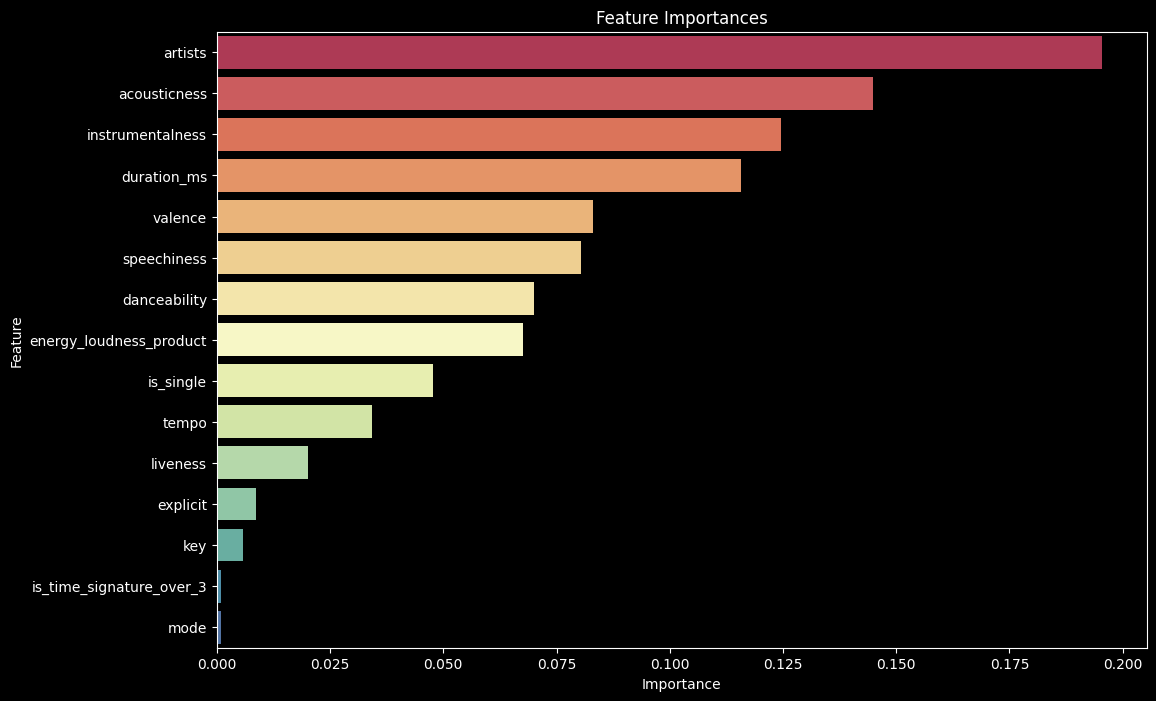

In [55]:
fi = best_forest.feature_importances_
fi_df = pd.DataFrame({
    'Feature': x_train_z.columns,
    'Importance': fi
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data=fi_df, x='Importance', y='Feature', palette='Spectral')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Кросс-валидация

In [66]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []
x, y = data_wo_zeroes.drop(columns=['popularity']), data_wo_zeroes['popularity']
for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_forest.fit(x_train, y_train)
    y_pred = best_forest.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)

print('n_fold\tMSE\tR2')
for i in range(len(mse_scores)):
    print(f'{i+1}\t{mse_scores[i]:.1f}\t{r2_scores[i]:.5f}')

print(f'\nСредний MSE: {np.mean(mse_scores):.1f}')
print(f'Средний R2: {np.mean(r2_scores):.5f}')

n_fold	MSE	R2
1	304.0	0.18031
2	291.1	0.21059
3	295.8	0.20477
4	292.4	0.20228
5	288.5	0.22313

Средний MSE: 294.4
Средний R2: 0.20422
